# Case Study: Cyclisystic Bike Rental Company

## Introduction

This case study was carried out as a part of the Capstone Project for Google Data Analytics Professional Certification. Multiple software applications have been utilized for analysis, although one or two of them were sufficient, to incorporate all the tools learnt in certification.

## Scenario

In 2016, ‘Cyclistic’ launched a successful bike-share offering based in Chicago. The director of marketing believes the company’s future success depends on maximizing the number of annual memberships. As a Data Analyst, work along with your team to understand how casual riders and annual members use Cyclistic bikes differently.

## Business Task

Analyse the previous 12 months of data to gain insights on the main differences in the behaviour between the two types of users to come up with a marketing campaign whose goal is to convert casual riders into annual members.

## Preparing Data

The dataset consists of Cyclistic’s historical trip data from November 2020 to October 2021, stored as 12 CSV files, one for each month. The data has been made available by Motivate International Inc. under this license. Each file contains 13 fields:

* **ride_id:** Unique ID for each ride taken by the customer
* **rideable_type:** Type of bicycle among classic_bike, dock_bike and electric_bike
* **started_at:** Time at which the ride started
* **ended_at:** Time at which the ride ended
* **start_station_name:** Station at which the ride started
* **start_station_id:** The ID of the station at which the ride started
* **end_station_name:** Station at which the ride ended
* **end_station_id:** The ID of the station at which the ride ended
* **start_lat:** The latitude of the station at which the ride started
* **start_lng:** The longitude of the station at which the ride started
* **end_lat:** The latitude of the station at which the ride ended
* **end_lng:** The longitude of the station at which the ride ended
* **member_casual:** Type of user among member or casual

Initial examination of the dataset by utilizing filters in Microsoft Excel reveals multiple null values and also inconsistencies in naming and formatting, thus making data cleaning the next step towards effective analysis.  Apart from data cleaning, CSV files need to be merged and new fields must be created by manipulating the existing ones in a way that makes analysis and visualization more convenient.


## Cleaning Data

For cleaning data, the CSV files are imported to BigQuery since the dataset was too large to load quickly in MySQL workbench.

### Making the Format of Station ID Consistent

The data type of start_station_id and end_station_id of November 2020 were found to be different from that of the rest of the months. These fields are automatically assigned as integers while those of other months are assigned as strings. A <a href="https://console.cloud.google.com/bigquery?sq=8163809308:a5bb0d76b0cd4535b0082ff00377eb3a" target="_blank">query</a> was run to cast integer to string since BigQuery does not support changing the datatype of fields.

### Combining Datasets

Once this was successful, a <a href="https://console.cloud.google.com/bigquery?sq=8163809308:a1f7f47106474008b062eedb3f0a0239" target="_blank">query</a> was run to unite the data of all the months. The number of records in the resulting table corresponds to the sum of records in all the CSV files, thus confirming that the query was successful. The resulting table contains 5,378,834 rows of data. Note that this query result still contains null and duplicate values. Further cleaning is necessary for analysis. 

### Removing Duplicate ride_id and Inconsistent Dates

Another <a href="https://console.cloud.google.com/bigquery?sq=8163809308:ec3d2f587a754ecf89cca084a679f492" target="_blank">query</a> was executed to determine whether any ride_id is repeating and found that 209 records have duplicate ride_id due to some data entry errors that lead to ride ending time being earlier than ride starting time in the dataset for December 2020. After further inspection, the same inconsistency was found in 139 records. A <a href="https://console.cloud.google.com/bigquery?sq=8163809308:c4ba70143c72407f96eac0b4a9b7ca95" target="_blank">query</a> was run to remove these records and the resulting table contains 5,376,953 rows of data.

### Removing Trips to Repair Shop

Several docking station data inconsistencies have to be eliminated to get cleaner data. The records of trips to and from the repair shop can be removed as they do not represent customer usage. A <a href="https://console.cloud.google.com/bigquery?sq=8163809308:a457786fa22842239fcd40e040e296ee" target="_blank">query</a> was run to execute this operation which resulted in a table containing 5,375,907 records.

### Replacing Null Values in Docking Station Name using Station ID

Multiple station names are associated with a single station ID and also some station names have multiple station IDs. Thus station ID and names are found to be unreliable. They are also purposeless during the data analysis stage and must therefore anyway be eliminated later in the cleaning process. But the station IDs associated with a single station are quite useful for replacing null values in the station name field with valid names and station names can be used to make the station coordinates consistent. 

A <a href="https://console.cloud.google.com/bigquery?sq=55822055480:5662acdb829c4bf4843c620d1af830b1" target="_blank">query</a> was executed to check whether the duplication of station ID can be avoided and if the multiple stations under the same ID are at the same geographical coordinates. After a detailed examination of the resulting table, it was found that some of them have the same station names with variations. A <a href="https://console.cloud.google.com/bigquery?sq=55822055480:ff8610229705411aaa406696fc9c9915" target="_blank">query</a> was run to eliminate this error and replace null values. 

### Replacing Null Values in Docking Station Name using Station Coordinates

Now replacing null values with valid values is only possible with the use of station coordinates. But here also multiple stations are associated with the same coordinates. So only the coordinates associated with a single station can be used to replace null values with valid ones. A <a href="https://console.cloud.google.com/bigquery?sq=8163809308:d9821c24f59e44458dfbd61c6c19e225" target="_blank">query</a> was run to achieve this.

But still, 636,732 rows of data where both start and end station names have null values since these rows also have null coordinates for both start and end stations. However, there are no rows where any one of them has a null value. 

### Making Station Coordinates Consistent

Latitude and longitude values differ slightly for the same station due to the accuracy and precision of the geo-trackers and this inconsistency has to be removed for convenient visualization. This can be done by executing a <a href="https://console.cloud.google.com/bigquery?sq=8163809308:da7a42c1ca4c4633b9a2e165a1d42eb5" target="_blank">query</a> to replace the coordinates in the table with the average value of coordinates corresponding to each station rounded to four decimal places.

### Removing Unwanted Columns and Adding New Columns

As mentioned previously, station IDs and names are not necessary for analysis and therefore they need to be removed from the table. Furthermore, new columns for trip duration, hour of the day, day of the week and month are needed for easier analysis. A <a href="https://console.cloud.google.com/bigquery?sq=8163809308:cf9cb4c4ae18402cb4873a8089472964" target="_blank">query</a> is executed to facilitate this requirement. Distance of each trip would not be included since for 88% of all rides, the ride ends at the same station from where it has started.

The resulting table still contains some records with null values for station coordinates, accounting for approximately 12% of the whole data. This wouldn’t cause a major issue during analysis since we still have 4,739,175 records of data with valid coordinates and also 5,375,907 records of other major parameters.

## Analysis

Rstudio was used for this step. Required libraries were installed and loaded. Then the data set is imported for analysis.

In [7]:
cyclistic_data <- read_csv("C:/Users/iammi/Downloads/Cyclistic/Processed_Dataset/final_data.csv")

Rows: 5375907 Columns: 13

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (7): ride_id, bike_type, starting_time, ending_time, day_of_week, month,...
dbl (6): hour_of_day, trip_duration_in_mins, start_lat, start_lng, end_lat, ...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



### Total Number of Rides Categorized by User Type

A pie chart is constructed to compare the distribution of the total number of rides taken by each type of user.

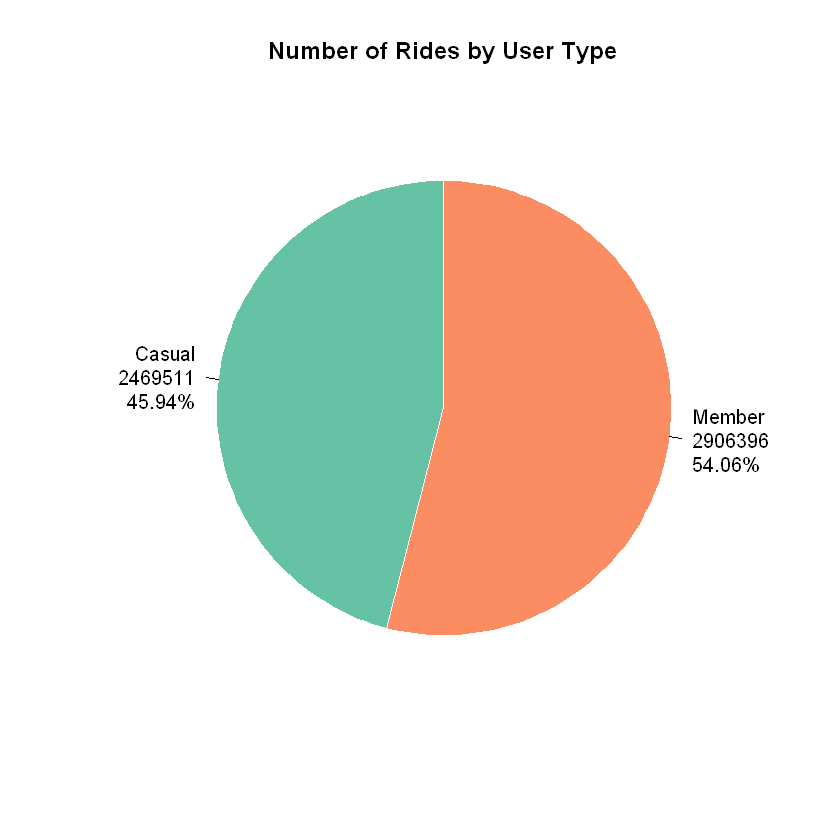

In [9]:
cyc_count <- table(as.factor(cyclistic_data$type_of_user))
percent_count <- round(100 * cyc_count / nrow(cyclistic_data), 2)
lbl_count <- paste(str_to_title(names(cyc_count)), cyc_count, 
             paste(percent_count, "%", sep = ""), 
             sep = "\n")

pie(cyc_count, 
    main = "Number of Rides by User Type",
    init.angle = 90,
    labels = lbl_count, 
    border = "white", 
    col = brewer.pal(3, "Set2"))

Even though the number of rides taken by casual riders falls behind that of the annual members, casual riders take 46% of the total rides, almost equal to that of annual members. 

### Total Duration of Rides Categorized by User Type

A pie chart is constructed to compare the distribution of the total time duration of rides taken by each type of user.

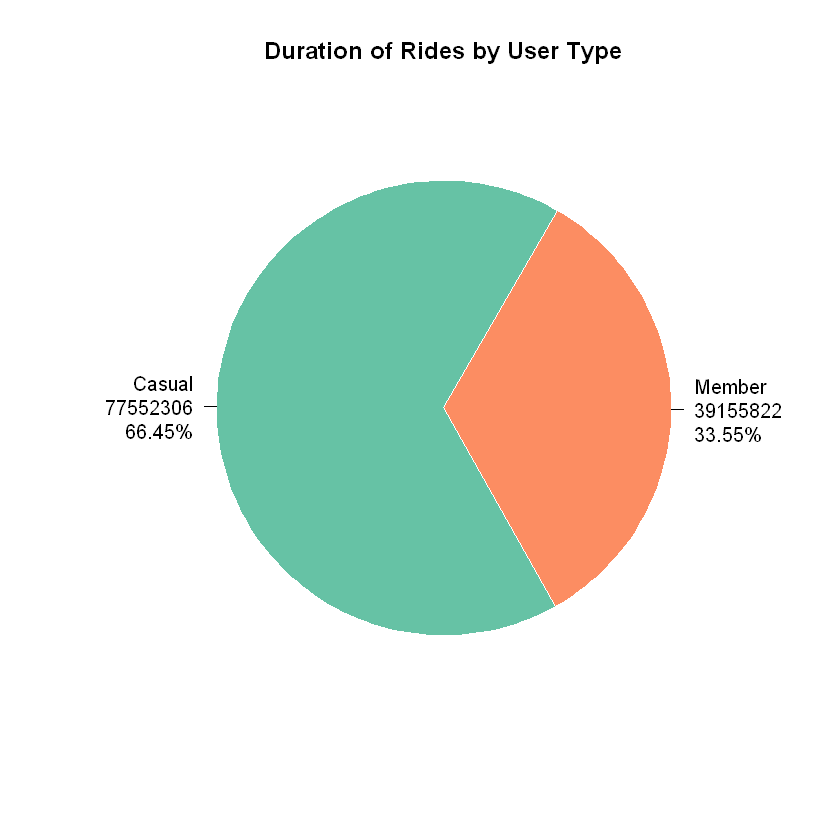

In [11]:
cyc_dur <- tapply(cyclistic_data$trip_duration_in_mins, 
                  cyclistic_data$type_of_user, FUN = sum)
percent_dur <- round(100 * cyc_dur / sum(cyclistic_data$trip_duration_in_mins), 2)
lbl_dur <- paste(str_to_title(names(cyc_dur)), cyc_dur,
                 paste(percent_dur, "%", sep = ""), 
                 sep = "\n")

pie(cyc_dur,
    main = "Duration of Rides by User Type",
    init.angle = 60,
    labels = lbl_dur,
    border = "white",
    col = brewer.pal(3, "Set2"))

Even though the number of rides by members exceeds that of casual riders, casual riders tend to take longer rides than annual members. 

### Average Duration of Ride Categorized by User Type 

A bar graph is constructed to compare the average duration of rides taken by each type of user.

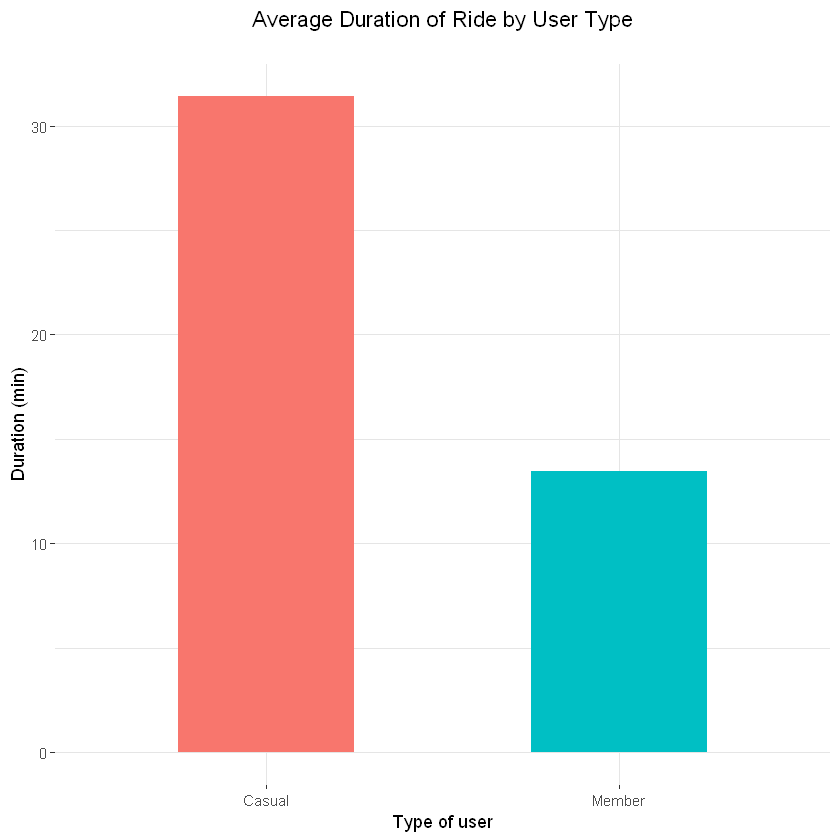

In [12]:
cyc_mean <- cyclistic_data %>% 
  group_by(type_of_user) %>% 
  summarise_at(vars(trip_duration_in_mins), list(mean_duration = mean))

ggplot(cyc_mean, aes(x = str_to_title(type_of_user), y = mean_duration, fill = type_of_user)) +
  geom_col(width = 0.5) +
  ggtitle("Average Duration of Ride by User Type\n") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Type of user", y = "Duration (min)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, linetype = 'solid',
                                    colour = "grey90"))

Even though the number of rides by members exceeds that of casual riders, casual riders tend to take longer rides than annual members. 

### Number of Rides of each type of Bike by Annual Members for each Month of the Year

A line graph is constructed to compare the popularity of each type of bike among annual members throughout the year.

`summarise()` has grouped output by 'bike_type'. You can override using the `.groups` argument.



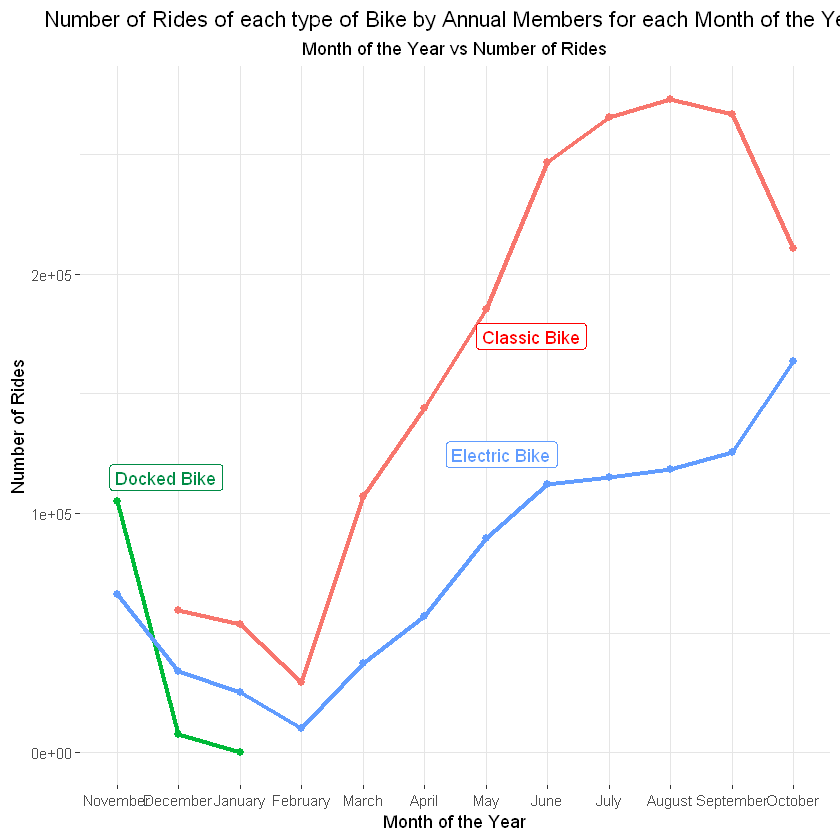

In [13]:
bike_pop <- cyclistic_data %>% 
  filter(type_of_user == "member") %>% 
  group_by(bike_type, month) %>% 
  summarise(popularity = n())
bike_pop$month <- factor(bike_pop$month, 
                            ordered = TRUE,
                            levels = c("November", "December", 
                                       "January", "February", 
                                       "March", "April", "May", 
                                       "June", "July", "August",
                                       "September", "October"))
bike_pop <- bike_pop[order(bike_pop$month), ]
ggplot(bike_pop, 
       aes(x = month, 
           y = popularity, 
           color = bike_type, 
           group = bike_type)) +
  geom_line(size = 1.2) +
  geom_label(label = "Electric Bike", 
             x = 7.25, y = 1.245e+05) +
  geom_label(label = "Classic Bike", 
             x = 7.73, y = 1.74e+05, 
             color = "Red") +
  geom_label(label = "Docked Bike", 
             x = 1.8, y = 1.15e+05, 
             color = "SpringGreen4") +
  geom_point(size = 2) +
  ggtitle("Number of Rides of each type of Bike by Annual Members for each Month of the Year",
          subtitle = "Month of the Year vs Number of Rides") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Month of the Year", y = "Number of Rides") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

The number of rides of electric bikes tends to be increasing while that of classic bikes is decreasing. It seems annual members ceased to use docked bikes after January.

### Number of Rides of each type of Bike by Casual Riders for each Month of the Year

A line graph is constructed to compare the popularity of each type of bike among casual riders throughout the year.

`summarise()` has grouped output by 'bike_type'. You can override using the `.groups` argument.



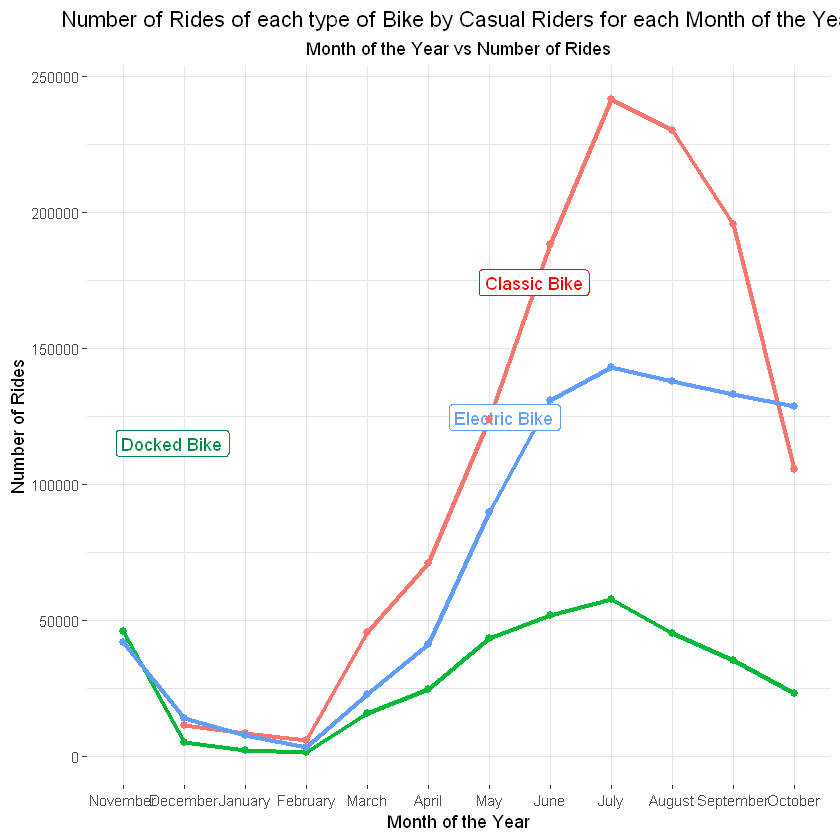

In [14]:
bike_pop <- cyclistic_data %>% 
  filter(type_of_user == "casual") %>% 
  group_by(bike_type, month) %>% 
  summarise(popularity = n())
bike_pop$month <- factor(bike_pop$month, 
                            ordered = TRUE,
                            levels = c("November", "December", 
                                       "January", "February", 
                                       "March", "April", "May", 
                                       "June", "July", "August",
                                       "September", "October"))
bike_pop <- bike_pop[order(bike_pop$month), ]
ggplot(bike_pop, 
       aes(x = month, 
           y = popularity, 
           color = bike_type, 
           group = bike_type)) +
  geom_line(size = 1.2) +
  geom_label(label = "Electric Bike", 
             x = 7.25, y = 1.245e+05) +
  geom_label(label = "Classic Bike", 
             x = 7.73, y = 1.74e+05, 
             color = "Red") +
  geom_label(label = "Docked Bike", 
             x = 1.8, y = 1.15e+05, 
             color = "SpringGreen4") +
  geom_point(size = 2) +
  ggtitle("Number of Rides of each type of Bike by Casual Riders for each Month of the Year",
          subtitle = "Month of the Year vs Number of Rides") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Month of the Year", y = "Number of Rides") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

The number of rides of all types of bikes seems to be decreasing, among which that of electric bikes is decreasing less.

### Total Number of Rides for each Hour of the Day Categorized by User Type

A line graph is constructed to compare the progression of the total number of rides taken by each type of user throughout a day.

`summarise()` has grouped output by 'type_of_user'. You can override using the `.groups` argument.



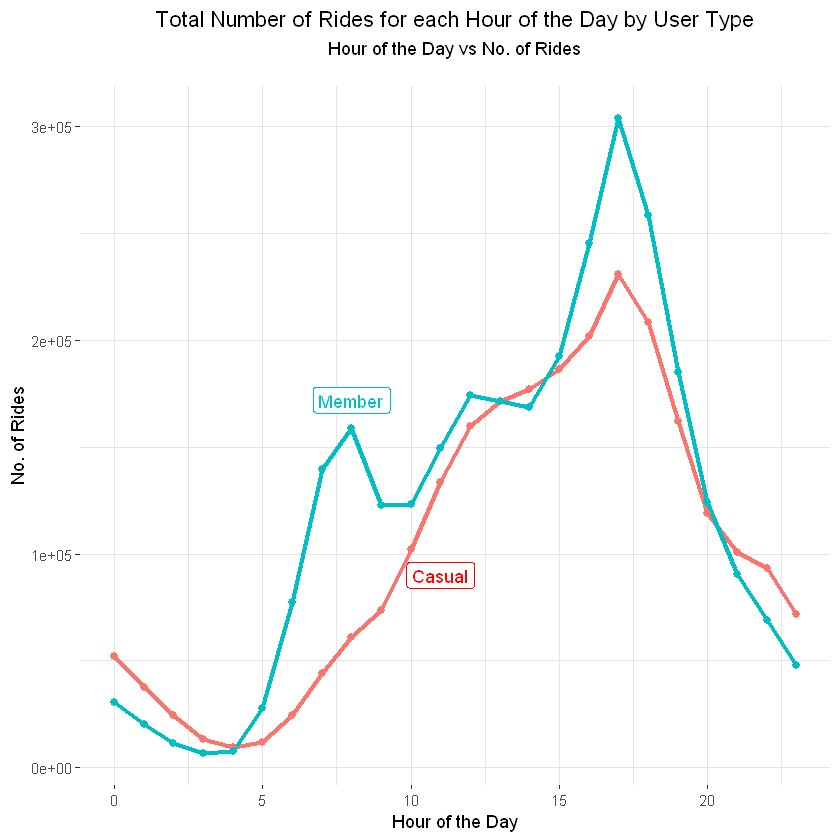

In [15]:
hour_count <- cyclistic_data %>% 
  group_by(type_of_user, hour_of_day) %>% summarize(num_of_rides = n())

ggplot(hour_count, aes(x = hour_of_day, y = num_of_rides, color = type_of_user)) + geom_line(size = 1.2) +
  geom_label(label = "Member", x = 8, y = 1.72e+05) +
  geom_label(label = "Casual", x = 11, y = 0.9e+05, color = "Red") +
  geom_point(size = 2) +
  ggtitle("Total Number of Rides for each Hour of the Day by User Type",
          subtitle = "Hour of the Day vs No. of Rides\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Hour of the Day", y = "No. of Rides") +
  theme(panel.background = element_rect(fill = "white", colour = "white",
                                    size = 0.5, linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, linetype = 'solid',
                                    colour = "grey90"))

The number of rides seems to be almost the same for both types of users except during office rush hours, where the graph of annual members sees a significant rise compared to casual riders. 

### Total Duration of Rides for each Hour of the Day Categorized by User Type

A line graph is constructed to compare the progression of the total time duration of rides taken by each type of user throughout a day.

`summarise()` has grouped output by 'type_of_user'. You can override using the `.groups` argument.



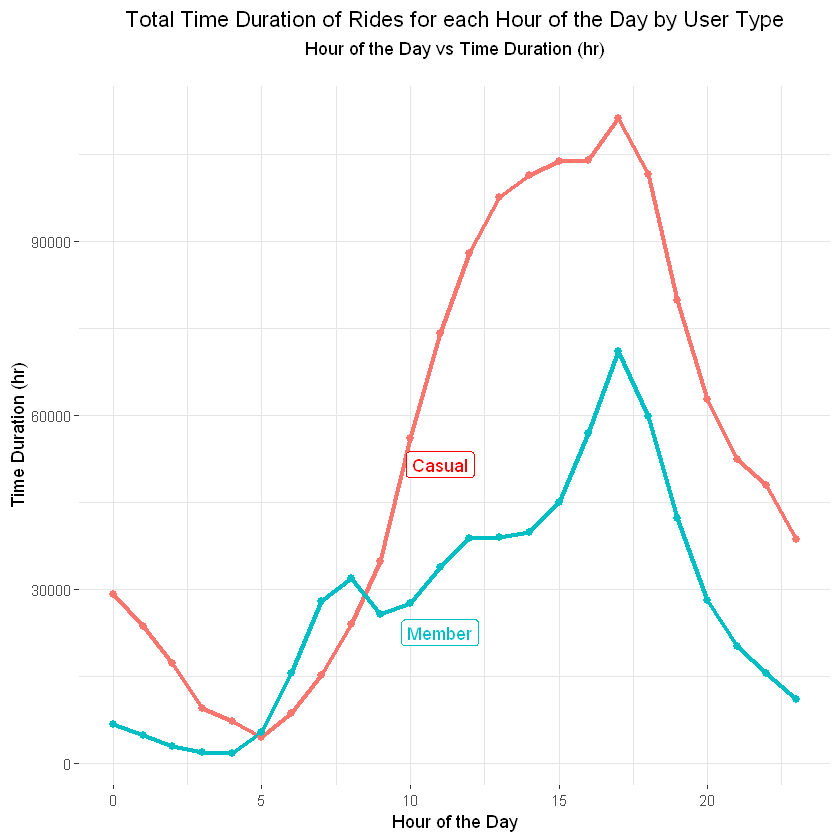

In [16]:
hour_dur <- cyclistic_data %>% 
  group_by(type_of_user, hour_of_day) %>% 
  summarize(total_dur = sum(trip_duration_in_mins))

ggplot(hour_dur, 
       aes(x = hour_of_day, 
           y = total_dur/60,
           color = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", x = 11, y = 22500) +
  geom_label(label = "Casual", x = 11, y = 51500, 
             color = "Red") +
  geom_point(size = 2) +
  ggtitle("Total Time Duration of Rides for each Hour of the Day by User Type",
          subtitle = "Hour of the Day vs Time Duration (hr)\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Hour of the Day", 
       y = "Time Duration (hr)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

Casual riders seem to ride longer than annual members especially during afternoon hours even though the number of rides taken by them almost aligns with that of annual members.

### Average Duration of Rides for each Hour of the Day Categorized by User Type

A line graph is constructed to compare the progression of the average time duration of rides taken by each type of user throughout a day.

`summarise()` has grouped output by 'type_of_user'. You can override using the `.groups` argument.



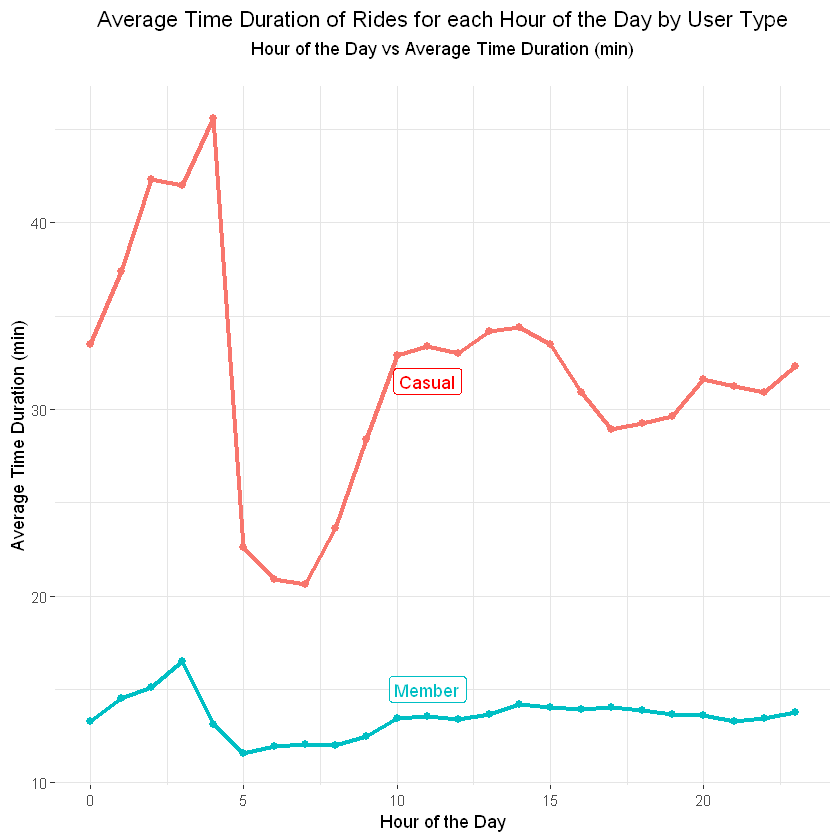

In [17]:
hour_avg <- cyclistic_data %>% 
  group_by(type_of_user, hour_of_day) %>% 
  summarize(avg_dur = mean(trip_duration_in_mins))

ggplot(hour_avg, aes(x = hour_of_day, y = avg_dur,
           color = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", x = 11, y = 15) +
  geom_label(label = "Casual", x = 11, y = 31.5, color = "Red") +
  geom_point(size = 2) +
  ggtitle("Average Time Duration of Rides for each Hour of the Day by User Type",
          subtitle = "Hour of the Day vs Average Time Duration (min)\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Hour of the Day", y = "Average Time Duration (min)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white", size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

Annual members seem to take short trips consistently, most probably for commuting. Casual members take longer rides, most probably to make the most out of the amount they paid for single-ride passes or full-day passes. A sudden rise can be observed in the early morning for both types of users as during these hours bikes might be used for exercising. 

### Total Number of Rides for each Day of the Week Categorized by User Type 

A line graph is constructed to compare the progression of the total number of rides taken by each type of user throughout a week.

`summarise()` has grouped output by 'day_of_week'. You can override using the `.groups` argument.



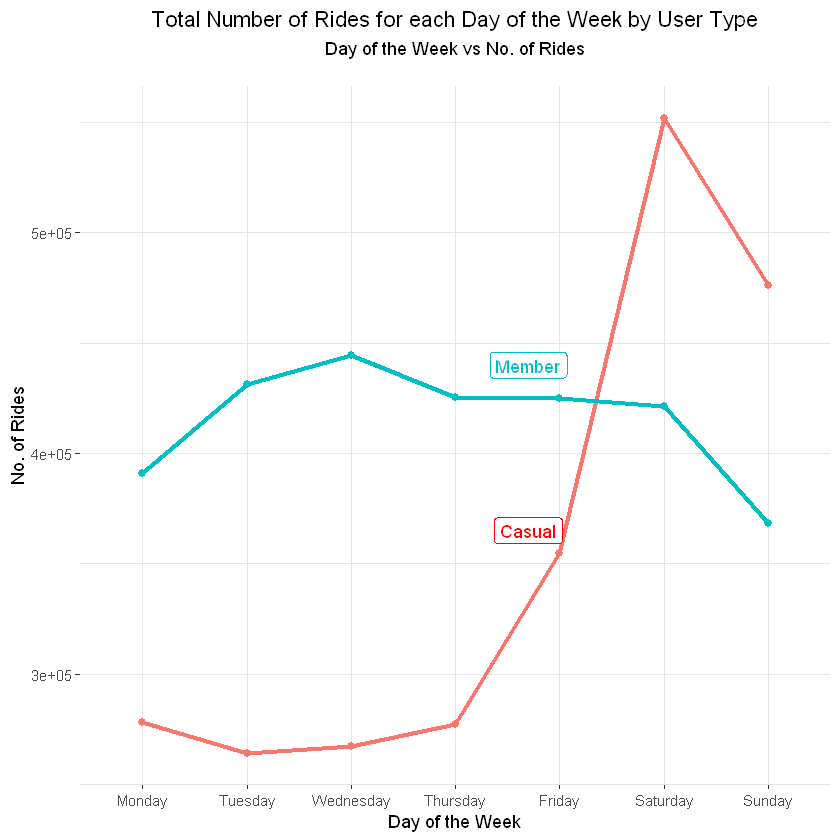

In [18]:
day_count <- cyclistic_data %>% 
  group_by(day_of_week, type_of_user) %>% 
  summarise(num_of_rides = n()) 

day_count$day_of_week <- factor(day_count$day_of_week, ordered = TRUE,
                                levels = c("Monday", "Tuesday", 
                                           "Wednesday", "Thursday",
                                           "Friday", "Saturday", 
                                           "Sunday"))
day_count <- day_count[order(day_count$day_of_week), ]

ggplot(day_count, 
       aes(x = day_of_week, 
           y = num_of_rides, 
           color = type_of_user, 
           group = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", 
             x = 4.7, y = 4.4e+05) +
  geom_label(label = "Casual", 
             x = 4.7, y = 3.65e+05, 
             color = "Red") +
  geom_point(size = 2) +
  ggtitle("Total Number of Rides for each Day of the Week by User Type",
          subtitle = "Day of the Week vs No. of Rides\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Day of the Week", y = "No. of Rides") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

The number of rides seems higher for annual members during weekdays and casual riders for weekends. 

### Total Duration of Rides for each Day of the Week Categorized by User Type

A line graph is constructed to compare the progression of the total time duration of rides taken by each type of user throughout a week.

`summarise()` has grouped output by 'day_of_week'. You can override using the `.groups` argument.



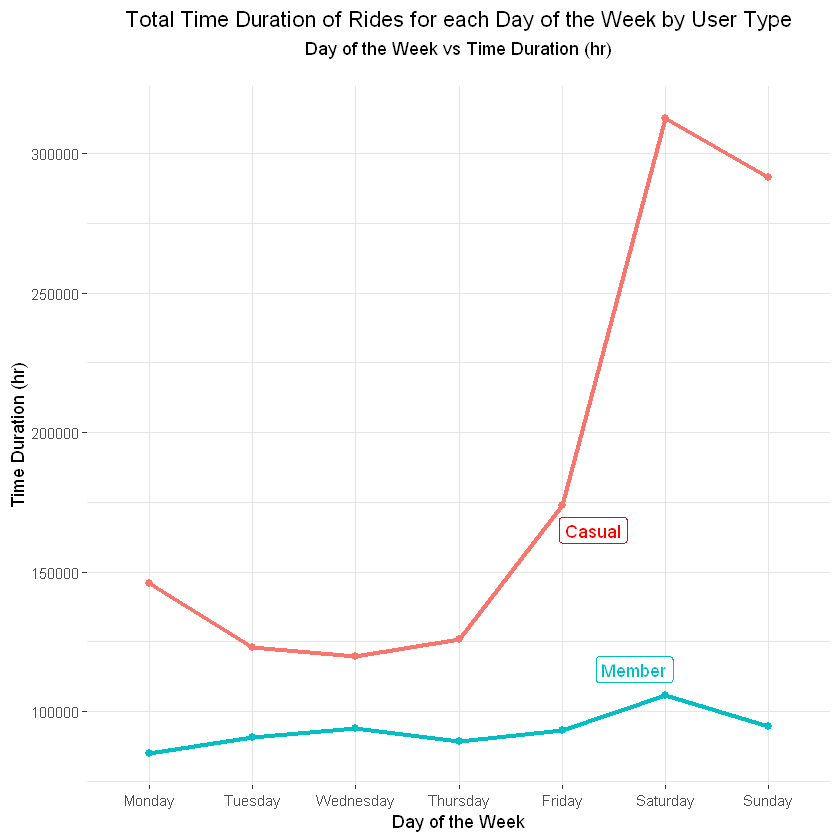

In [19]:
day_dur <- cyclistic_data %>% 
  group_by(day_of_week, type_of_user) %>% 
  summarise(total_dur = sum(trip_duration_in_mins)) 
day_dur$day_of_week <- factor(day_dur$day_of_week, ordered = TRUE,
                              levels = c("Monday", "Tuesday",
                                         "Wednesday", "Thursday", 
                                         "Friday", "Saturday", 
                                         "Sunday"))
day_dur <- day_dur[order(day_dur$day_of_week), ]
ggplot(day_dur, 
       aes(x = day_of_week, y = total_dur/60, 
           color = type_of_user, group = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", 
             x = 5.7, y = 115000) +
  geom_label(label = "Casual", 
             x = 5.3, y = 165000, color = "Red") +
  geom_point(size = 2) +
  ggtitle("Total Time Duration of Rides for each Day of the Week by User Type",
          subtitle = "Day of the Week vs Time Duration (hr)\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Day of the Week", y = "Time Duration (hr)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

Casual riders seem to ride longer than annual members every day with a steep rise during the weekend. This behavior can be accounted for making the most out of the amount they paid for single-ride passes or full-day passes.

### Average Duration of Rides for each Day of the Week Categorized by User Type

A line graph is constructed to compare the progression of the average time duration of rides taken by each type of user throughout a week.

`summarise()` has grouped output by 'day_of_week'. You can override using the `.groups` argument.



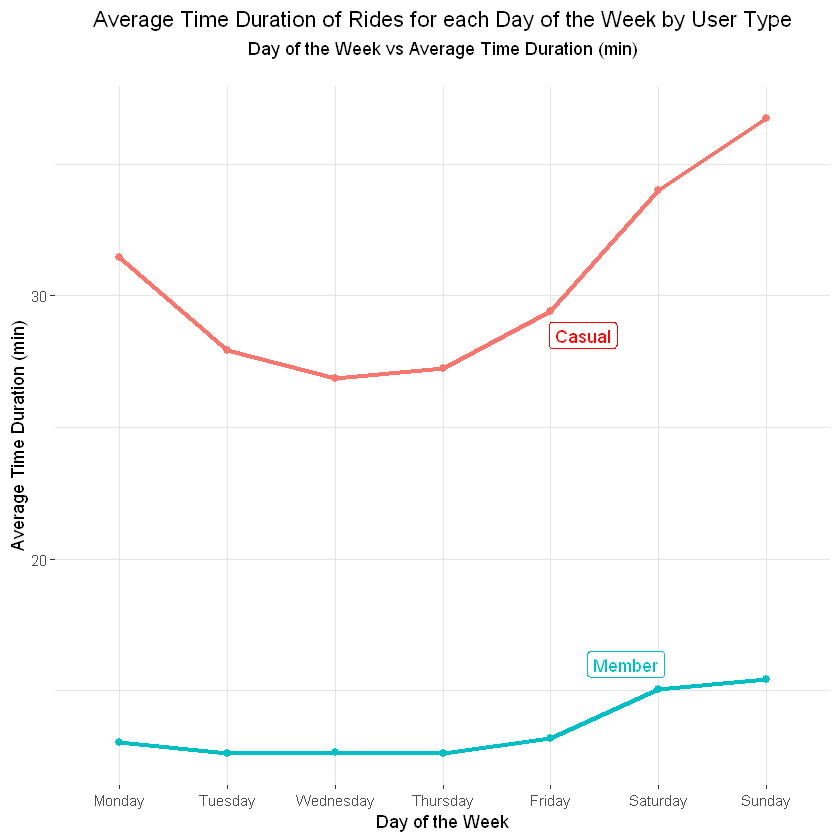

In [20]:
day_avg <- cyclistic_data %>% 
  group_by(day_of_week, type_of_user) %>% 
  summarise(avg_dur = mean(trip_duration_in_mins)) 

day_avg$day_of_week <- factor(day_avg$day_of_week, ordered = TRUE,
                              levels = c("Monday", "Tuesday",
                                         "Wednesday", "Thursday", 
                                         "Friday", "Saturday", 
                                         "Sunday"))
day_avg <- day_avg[order(day_avg$day_of_week), ]

ggplot(day_avg, aes(x = day_of_week, 
                    y = avg_dur,
                    color = type_of_user, 
                    group = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", x = 5.7, y = 16) +
  geom_label(label = "Casual", x = 5.3, y = 28.5, color = "Red") +
  geom_point(size = 2) +
  ggtitle("Average Time Duration of Rides for each Day of the Week by User Type",
          subtitle = "Day of the Week vs Average Time Duration (min)\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Day of the Week", y = "Average Time Duration (min)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white", 
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

Annual members seem to take short trips consistently, most probably for commuting. Casual members take longer rides, most probably to make the most out of the amount they paid for single-ride passes or full-day passes. A sudden rise can be observed for casual riders during weekends. This might be an indication of using bikes for leisure activities. 

### Total Number of Rides for each Month of the Year Categorized by User Type

A line graph is constructed to compare the progression of the total number of rides taken by each type of user throughout the year. The factors of the x-axis are months from November 2020 to October 2021, in the order of the dataset.

`summarise()` has grouped output by 'type_of_user'. You can override using the `.groups` argument.



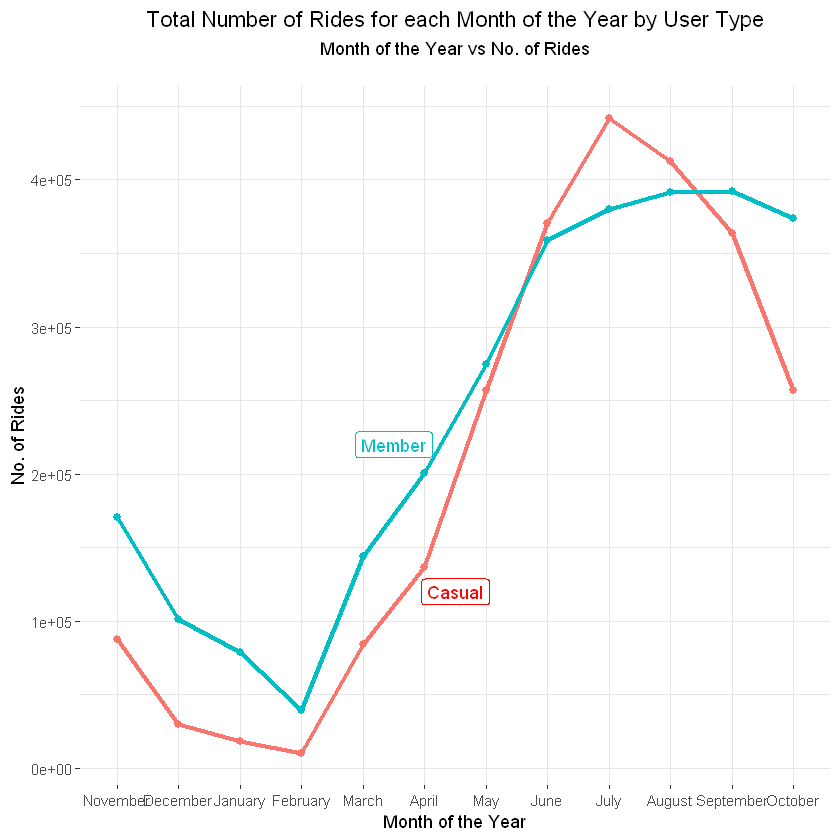

In [21]:
month_count <- cyclistic_data %>% 
  group_by(type_of_user, month) %>% summarise(num_of_rides = n())
month_count$month <- factor(month_count$month, ordered = TRUE,
                            levels = c("November", "December", 
                                       "January", "February", 
                                       "March", "April", "May", 
                                       "June", "July", "August",
                                       "September", "October"))
month_count <- month_count[order(month_count$month), ]
ggplot(month_count, 
       aes(x = month, y = num_of_rides, 
           color = type_of_user, group = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", 
             x = 5.5, y = 2.2e+05) +
  geom_label(label = "Casual", 
             x = 6.5, y = 1.2e+05, color = "Red") +
  geom_point(size = 2) +
  ggtitle("Total Number of Rides for each Month of the Year by User Type",
          subtitle = "Month of the Year vs No. of Rides\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Month of the Year", y = "No. of Rides") +
  theme(
    panel.background = element_rect(fill = "white", colour = "white",
                                    size = 0.5, linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

The number of rides seems higher for annual members throughout the year except during the summer months.

### Total Duration of Rides for each Month of the Year Categorized by User Type

A line graph is constructed to compare the progression of the total time duration of rides taken by each type of user throughout the year. The factors of the x-axis are months from November 2020 to October 2021, in the order of the dataset.

`summarise()` has grouped output by 'type_of_user'. You can override using the `.groups` argument.



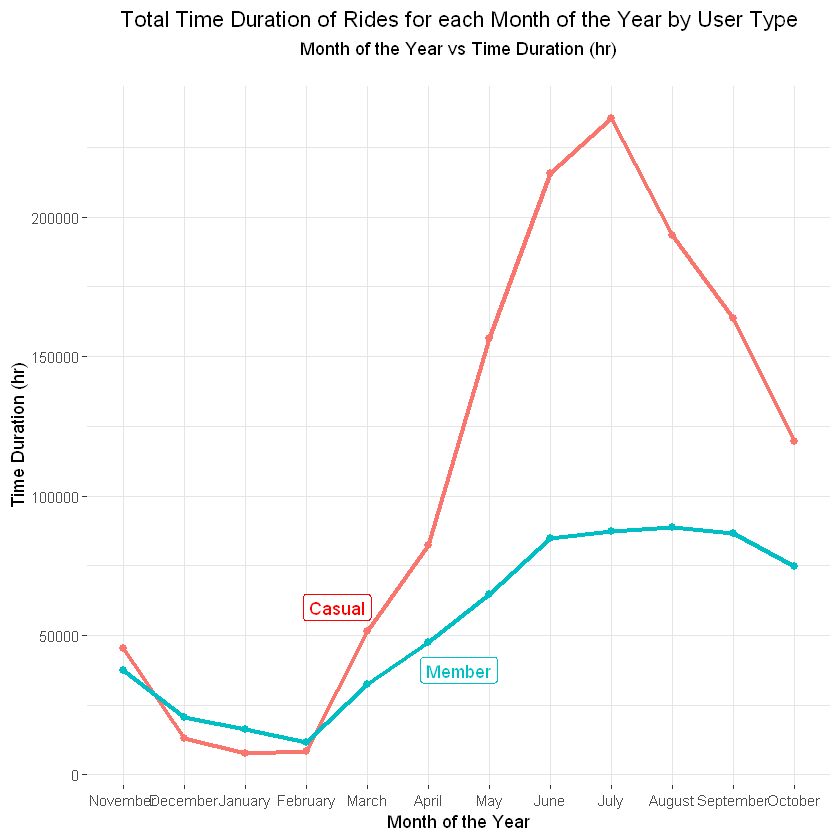

In [22]:
month_dur <- cyclistic_data %>% 
  group_by(type_of_user, month) %>% 
  summarise(total_dur = sum(trip_duration_in_mins))
month_dur$month <- factor(month_dur$month, 
                            ordered = TRUE,
                            levels = c("November", "December", 
                                       "January", "February", 
                                       "March", "April", "May", 
                                       "June", "July", "August",
                                       "September", "October"))
month_dur <- month_dur[order(month_dur$month), ]
ggplot(month_dur, 
       aes(x = month, 
           y = total_dur/60, 
           color = type_of_user, 
           group = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", 
             x = 6.5, y = 37500) +
  geom_label(label = "Casual", 
             x = 4.5, y = 60000, 
             color = "Red") +
  geom_point(size = 2) +
  ggtitle("Total Time Duration of Rides for each Month of the Year by User Type",
          subtitle = "Month of the Year vs Time Duration (hr)\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Month of the Year", y = "Time Duration (hr)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

The length of rides seems to be almost the same for both types of users throughout the year except during the summer months, where duration of rides of casual riders are significantly higher than that of annual members.

### Average Duration of Rides for each Month of the Year Categorized by User Type

A line graph is constructed to compare the progression of the average time duration of rides taken by each type of user throughout the year. The factors of the x-axis are months from November 2020 to October 2021, in the order of the dataset.

`summarise()` has grouped output by 'type_of_user'. You can override using the `.groups` argument.



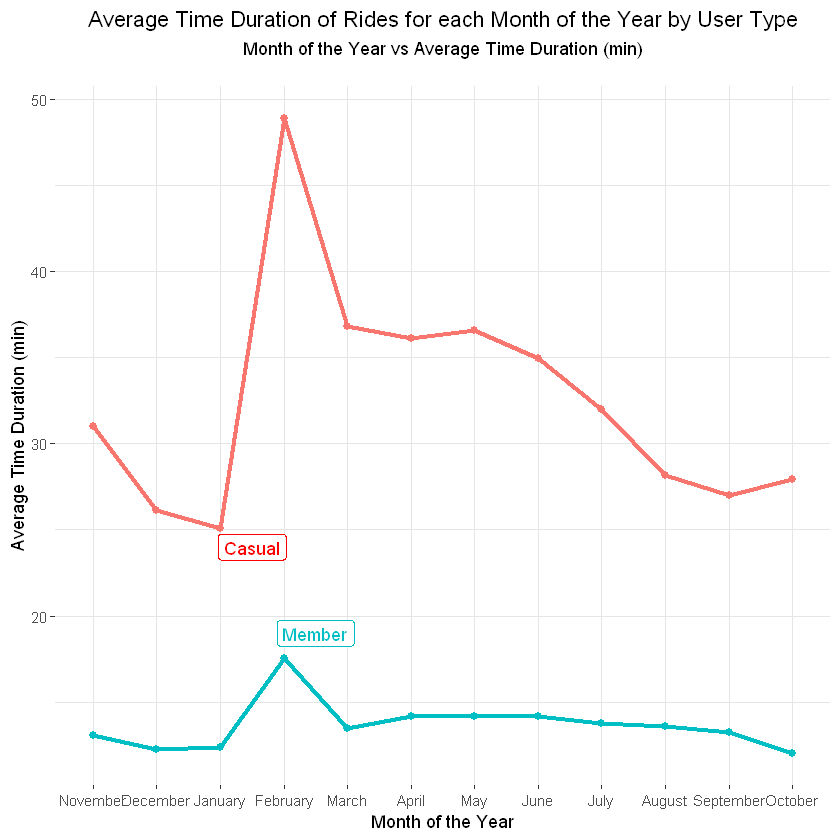

In [23]:
month_avg <- cyclistic_data %>% 
  group_by(type_of_user, month) %>% 
  summarise(avg_dur = mean(trip_duration_in_mins))

month_avg$month <- factor(month_avg$month, 
                          ordered = TRUE,
                          levels = c("November", "December", 
                                     "January", "February", 
                                     "March", "April", "May", 
                                     "June", "July", "August",
                                     "September", "October"))

month_avg <- month_avg[order(month_avg$month), ]

ggplot(month_avg, aes(x = month,
                      y = avg_dur,
                      color = type_of_user, 
                      group = type_of_user)) +
  geom_line(size = 1.2) +
  geom_label(label = "Member", 
             x = 4.5, y = 19) +
  geom_label(label = "Casual", 
             x = 3.5, y = 24, 
             color = "Red") +
  geom_point(size = 2) +
  ggtitle("Average Time Duration of Rides for each Month of the Year by User Type",
          subtitle = "Month of the Year vs Average Time Duration (min)\n") +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        legend.position = "none") +
  labs(x = "Month of the Year", y = "Average Time Duration (min)") +
  theme(
    panel.background = element_rect(fill = "white",
                                    colour = "white", 
                                    size = 0.5, 
                                    linetype = "solid"),
    panel.grid.major = element_line(size = 0.5, 
                                    linetype = 'solid',
                                    colour = "grey90"), 
    panel.grid.minor = element_line(size = 0.25, 
                                    linetype = 'solid',
                                    colour = "grey90"))

Annual members seem to take short trips consistently, most probably for commuting. Casual members take longer rides, most probably to make the most out of the amount they paid for single-ride passes or full-day passes. 

### Location of the Docking Stations

A geospatial graph is constructed to visualize the docking stations of rides taken by each type of user throughout the year. 

Source : http://tile.stamen.com/terrain/10/262/379.png

Source : http://tile.stamen.com/terrain/10/263/379.png

Source : http://tile.stamen.com/terrain/10/262/380.png

Source : http://tile.stamen.com/terrain/10/263/380.png

Source : http://tile.stamen.com/terrain/10/262/381.png

Source : http://tile.stamen.com/terrain/10/263/381.png

`summarise()` has grouped output by 'start_lat'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'start_lat'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'end_lat'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'end_lat'. You can override using the `.groups` argument.



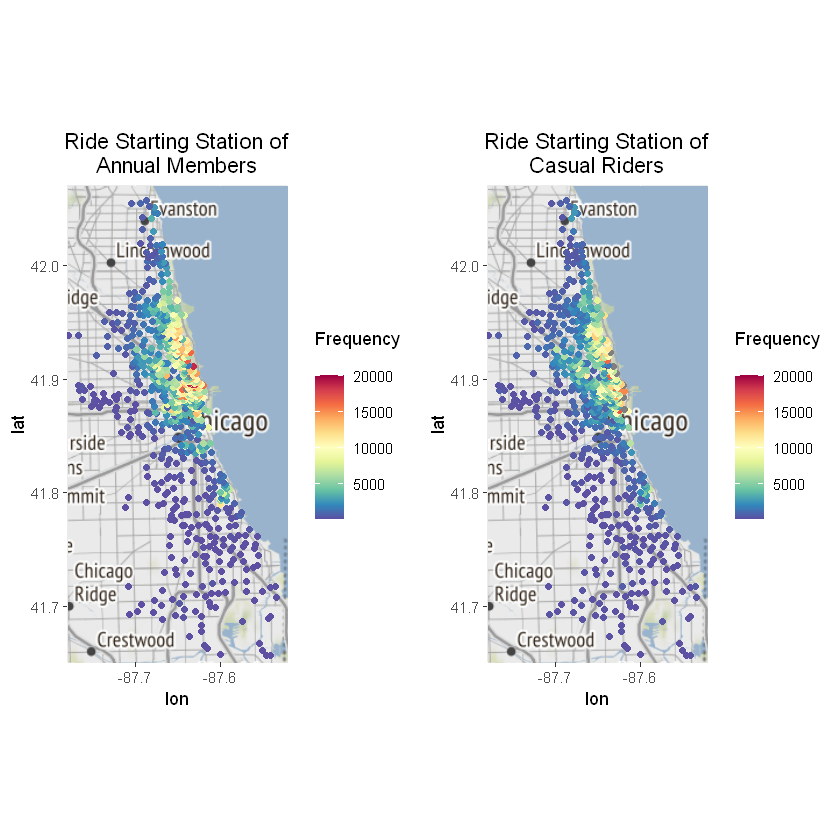

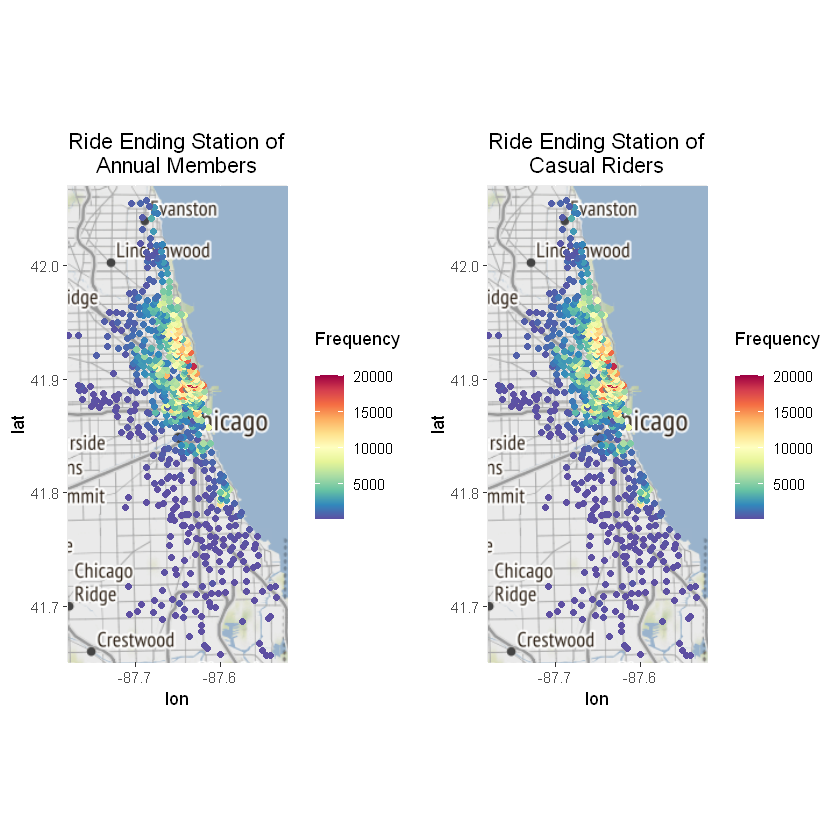

In [24]:
ride_map <- get_stamenmap(
  bbox = c(
    left = -87.78,
    right = -87.52,
    top = 42.07,
    bottom = 41.65
  ),
  maptype = "terrain"
)

myPalette <- colorRampPalette(rev(brewer.pal(11, "Spectral")))
sf <- scale_colour_gradientn(colours = myPalette(100), limits=c(1, 20000))
start_coord_mem <- cyclistic_data %>% 
  filter(type_of_user == "member") %>% 
  select(start_lat, start_lng) %>% 
  na.omit() %>% 
  group_by(start_lat, start_lng) %>% 
  summarize(frequency = n())
sm <- ggmap(ride_map) + 
  geom_point(data = start_coord_mem, aes(x = start_lng,
                                         y = start_lat,
                                         color = frequency)) +
  ggtitle("Ride Starting Station of\nAnnual Members") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(colour = "Frequency\n") + 
  sf

start_coord_cas <- cyclistic_data %>% 
  filter(type_of_user == "casual") %>% 
  select(start_lat, start_lng) %>% 
  na.omit() %>% 
  group_by(start_lat, start_lng) %>% 
  summarize(frequency = n())
sc <- ggmap(ride_map) + 
  geom_point(data = start_coord_cas, aes(x = start_lng,
                                         y = start_lat,
                                         color = frequency)) +
  ggtitle("Ride Starting Station of\nCasual Riders") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(colour = "Frequency\n") + 
  sf

end_coord_mem <- cyclistic_data %>% 
  filter(type_of_user == "member") %>% 
  select(end_lat, end_lng) %>% 
  na.omit() %>% 
  group_by(end_lat, end_lng) %>% 
  summarize(frequency = n())
em <- ggmap(ride_map) + 
  geom_point(data = end_coord_mem, aes(x = end_lng,
                                         y = end_lat,
                                         color = frequency)) +
  ggtitle("Ride Ending Station of\nAnnual Members") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(colour = "Frequency\n") + 
  sf

end_coord_cas <- cyclistic_data %>% 
  filter(type_of_user == "casual") %>% 
  select(end_lat, end_lng) %>% 
  na.omit() %>% 
  group_by(end_lat, end_lng) %>% 
  summarize(frequency = n())
ec <- ggmap(ride_map) + 
  geom_point(data = end_coord_mem, aes(x = end_lng,
                                       y = end_lat,
                                       color = frequency)) +
  ggtitle("Ride Ending Station of\nCasual Riders") +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(colour = "Frequency\n") + 
  sf

ggarrange(sm, sc)
ggarrange(em, ec)

Use of docking stations by each type of user seems to be identical. Thus, any useful conclusions about differences in use by each user type cannot be derived from location data. But we can observe that use of service is concentrated in the Downtown Chicago area.

## Data Visualization

Click <a href="https://public.tableau.com/views/Cyclistic_16391927710350/Dashboard2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link" target="_blank">here</a> to view the data visualization.

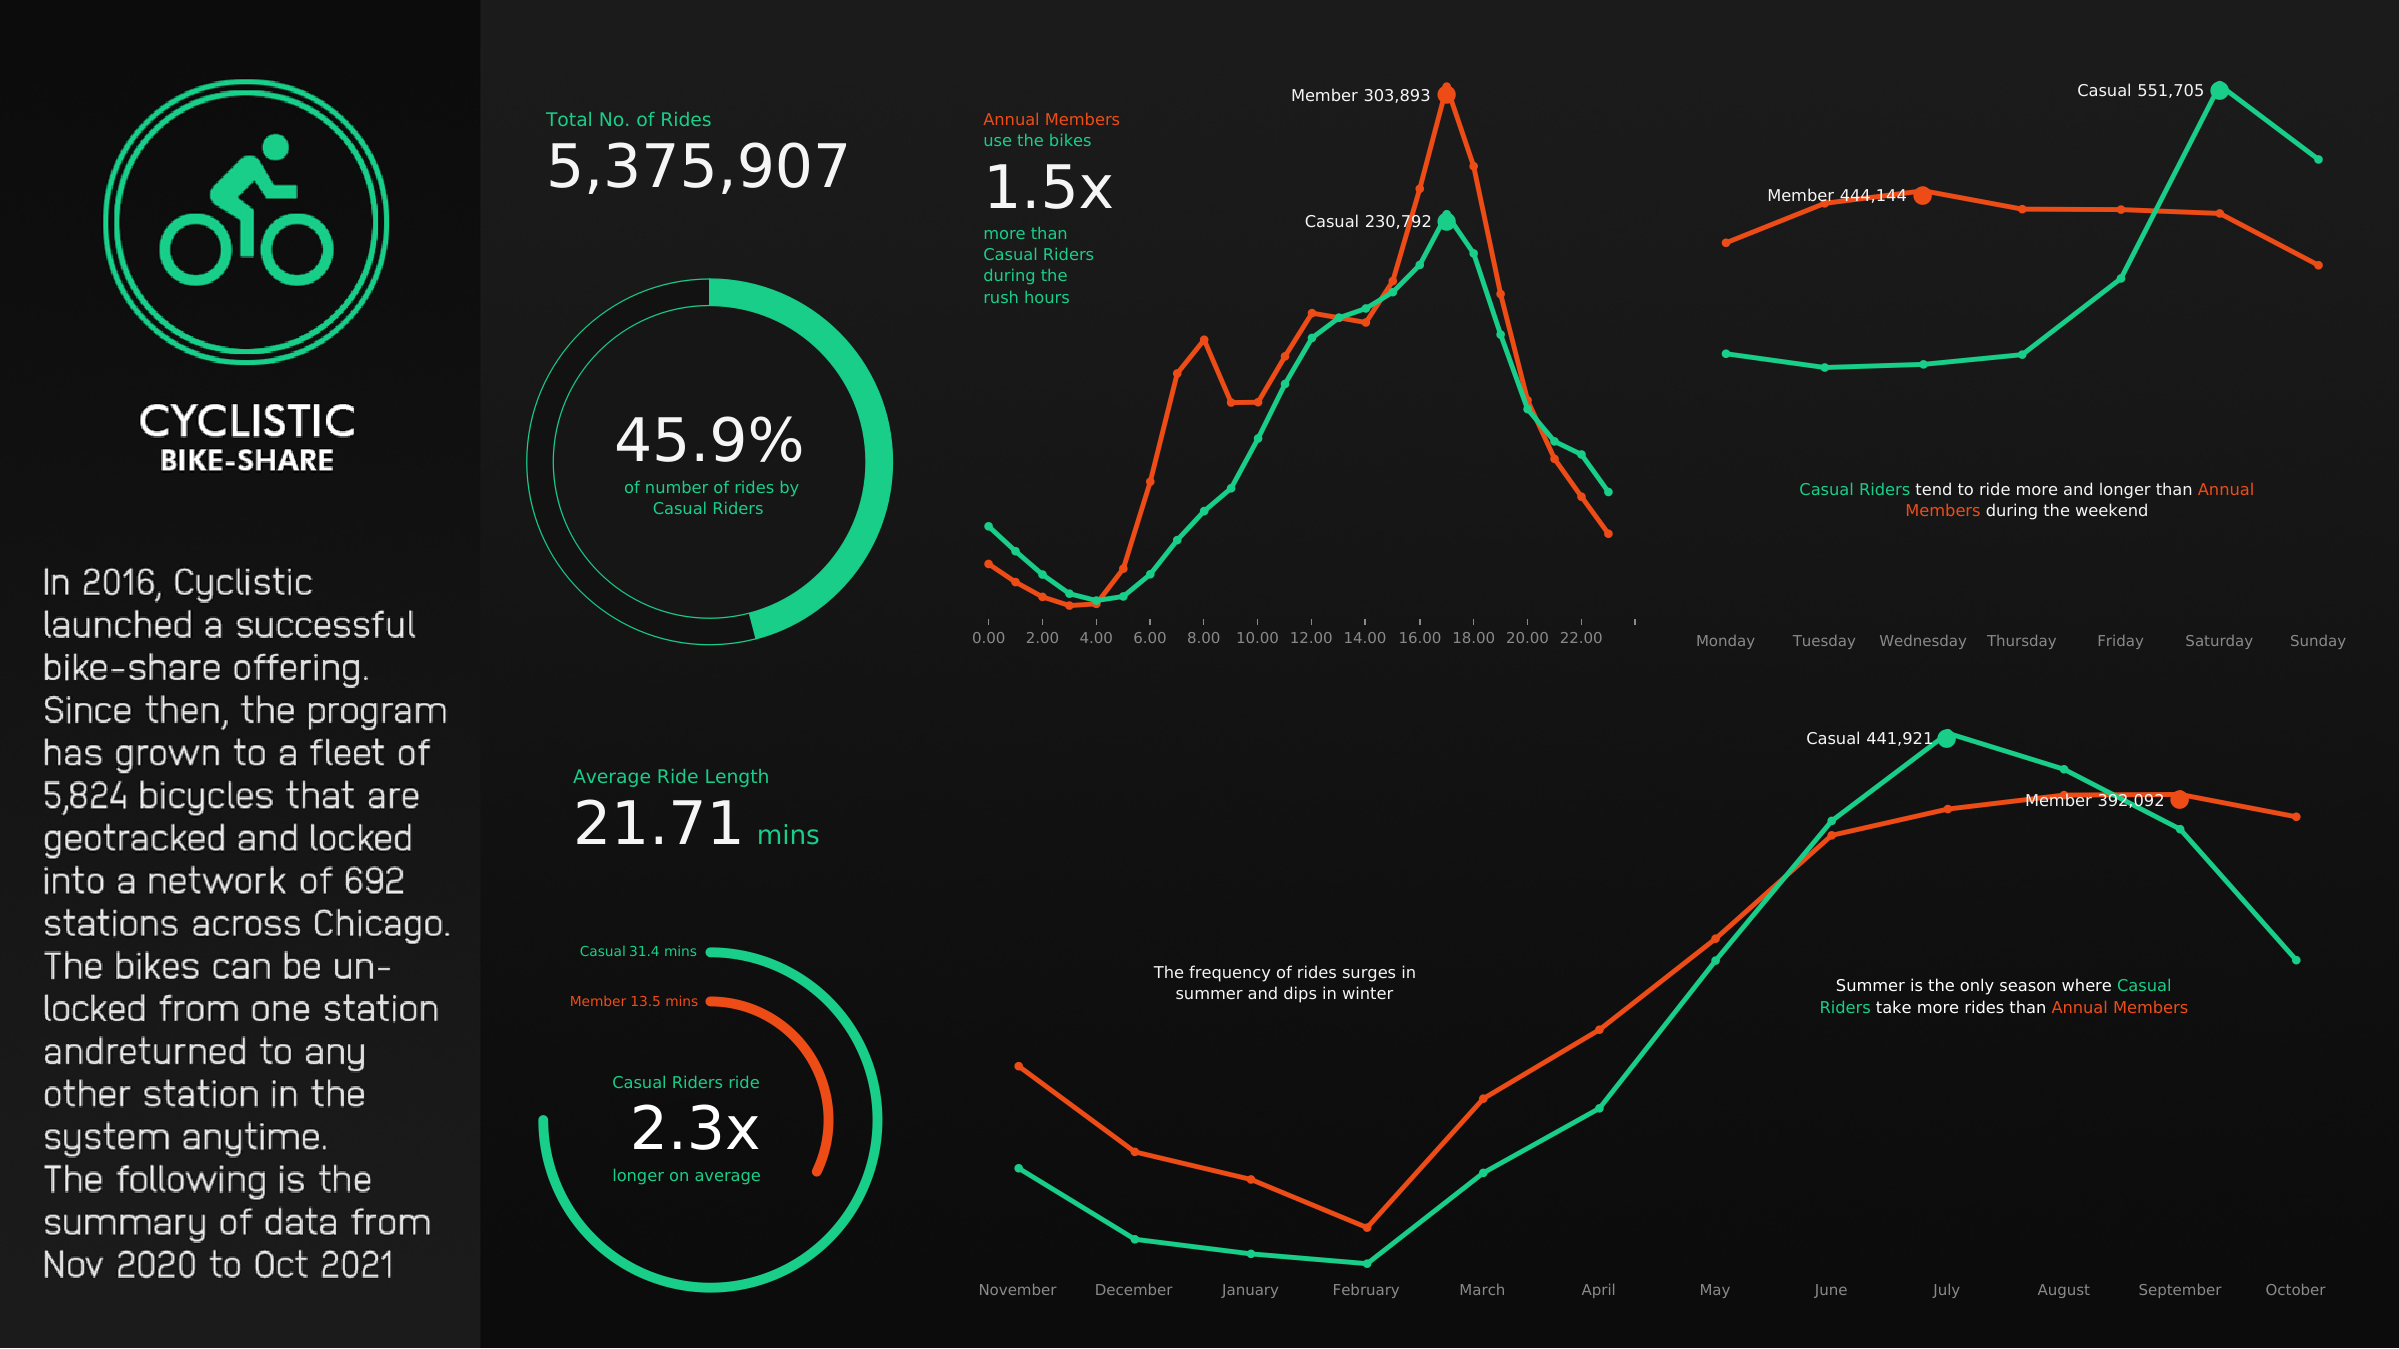

## Insights

The insights derived from the analysis are listed below:

* **Number of rides:** Annual members ride 1.2 times as much as casual riders. 
* **Type of bike:** Electric bikes seem to be the most popular choice among the three types of bikes.
* **Length of rides:** On average, casual riders tend to ride 2.3 times longer than annual members.
* **Hour of the day:** Annual members tend to use the bikes 1.5 times more than casual riders during the rush hours. Otherwise, the usage is almost identical.
* **Day of the week:** Casual riders tend to ride more and longer than annual members during the weekend. Weekends seem to be the most popular days as both annual members and casual riders alike take longer rides on weekends.
* **Month of the Year:** The frequency of rides surges in summer and dips in winter. Summer is the only season where casual riders take more rides than annual members.
* **Location:** Downtown Chicago is the most popular location for riding for both types of users.

The following are the differences between annual members and casual riders that were found based on the above insights derived from the analysis:

* **Annual members:** Use the bikes more during weekdays, particularly during rush hours, have a shorter average trip duration, most probably because they use it only when it's necessary and relatively less drop off during the winter months compared to casual customers since they mostly use the service regularly.
* **Casual riders:** Use the bikes more on the weekend, for traveling to and from recreational areas especially during the afternoon hours with a longer average trip duration, probably to make the most out of their single-ride passes and significantly less use during winter months since they mostly use the service for leisure activities. Casual riders also become significantly more active during the summer months when a lot of outdoor activities take place.

From this information, we can hypothesize that annual members use the service for commuting purposes and casual riders for recreational purposes but solid conclusions cannot be drawn from this information as we do not possess the personal and professional details of any users like age, gender, profession, motivation aspects like environment, health or finance etc. 

The company is missing out on a huge chunk of revenue by not charging rides proportional to the duration of the trip since the number of rides taken by both types of users are almost the same. 


## Recommendations

There are two possible ways in which we can proceed, among which only one must be chosen:
1. Collect more data.
2. Proceed with the insights from the available data.

The selection of one from the above two ways depends on how early the business decisions need to be taken. If decisions need to be taken immediately it is best to choose the second option, otherwise, the first option will be suitable.

### Collect More Data

By acquiring more data, preferably personal and professional data, derivation of more meaningful data can be achieved. Thus, we will be able to confirm our hypothesis, helping the company to formulate more effective business decisions.

### Proceeding with the Insights from the Available Data

Recommendations based on the above data are:
1. Introduce two mid-level subscription packages, Annual Weekend Membership and Summer Membership, to capitalize on the popularity of the respective periods among the casual members.
2. Formulate an advertisement campaign spreading awareness of the environmental, health and financial benefits of riding bikes. This campaign should focus on  areas of recreational activities.
3. Introduce referral reward program aimed at annual members, for encouraging existing customers to recommend the subscription package to their friends, family and colleagues.
4. Add more electric bikes to inventory since it seems to be the most popular option among the three types of bikes.
5. Include special service or benefits like advance booking of bikes, discounted rates for the next membership term, rewards for completing a certain distance, etc. in membership subscriptions, which helps in customer retention too.